In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from PIL import Image

In [2]:
# Prepare torchvision MNIST datasets and loaders
print("Preparing MNIST datasets (torchvision)...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),            # [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST normalization
])

train_dataset = datasets.MNIST(root="data/MNIST", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="data/MNIST", train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

input_dim = 28 * 28
num_classes = 10

print(f"Device: {device}")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

Preparing MNIST datasets (torchvision)...
Device: cpu
Train batches: 235, Test batches: 40


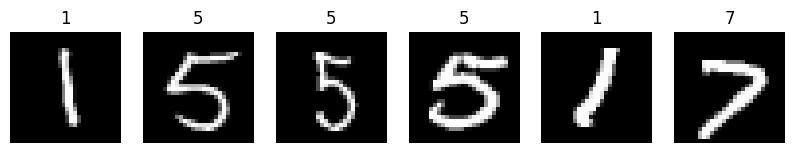

In [3]:
# Preview a few images from the DataLoader
np.set_printoptions(linewidth=200, threshold=784, suppress=True)

examples, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 6, figsize=(10, 2))
for i in range(6):
    axes[i].imshow(examples[i, 0].numpy(), cmap='gray')
    axes[i].set_title(int(labels[i]))
    axes[i].axis('off')
plt.show()

In [4]:
# Define a neural network with 2 hidden layers
class MNISTTwoHidden(nn.Module):
    def __init__(self, input_dim: int, hidden_dim1: int, hidden_dim2: int, num_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_classes)
        )

    def forward(self, x):
        return self.net(x)

hidden_dim1 = 16
hidden_dim2 = 16
model = MNISTTwoHidden(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

MNISTTwoHidden(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): ReLU()
    (5): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [5]:
# Train and evaluate
num_epochs = 10  # Increased epochs for better convergence with hidden layers
log_interval = 100

train_losses = []  # History of training losses
train_accuracies = []  # History of training accuracy
test_accuracies = []  # History of test accuracy

for epoch in range(1, num_epochs + 1):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (inputs, targets) in enumerate(train_loader, start=1):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % log_interval == 0:
            print(f"Epoch {epoch} [{batch_idx}/{len(train_loader)}] Loss: {running_loss/log_interval:.4f}")
            running_loss = 0.0

    train_acc = 100.0 * correct / total
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} training accuracy: {train_acc:.2f}%")

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies.append(test_acc)
    print(f"Epoch {epoch} test accuracy: {test_acc:.2f}%")

Epoch 1 [100/235] Loss: 1.1911
Epoch 1 [200/235] Loss: 0.4461
Epoch 1 training accuracy: 77.42%
Epoch 1 test accuracy: 89.85%
Epoch 2 [100/235] Loss: 0.3317
Epoch 2 [200/235] Loss: 0.3117
Epoch 2 training accuracy: 90.95%
Epoch 2 test accuracy: 91.94%
Epoch 3 [100/235] Loss: 0.2608
Epoch 3 [200/235] Loss: 0.2557
Epoch 3 training accuracy: 92.57%
Epoch 3 test accuracy: 92.89%
Epoch 4 [100/235] Loss: 0.2362
Epoch 4 [200/235] Loss: 0.2232
Epoch 4 training accuracy: 93.39%
Epoch 4 test accuracy: 93.43%
Epoch 5 [100/235] Loss: 0.2079
Epoch 5 [200/235] Loss: 0.2051
Epoch 5 training accuracy: 94.04%
Epoch 5 test accuracy: 93.91%
Epoch 6 [100/235] Loss: 0.1895
Epoch 6 [200/235] Loss: 0.1886
Epoch 6 training accuracy: 94.53%
Epoch 6 test accuracy: 94.01%
Epoch 7 [100/235] Loss: 0.1782
Epoch 7 [200/235] Loss: 0.1821
Epoch 7 training accuracy: 94.78%
Epoch 7 test accuracy: 94.46%
Epoch 8 [100/235] Loss: 0.1662
Epoch 8 [200/235] Loss: 0.1741
Epoch 8 training accuracy: 95.10%
Epoch 8 test accuracy:

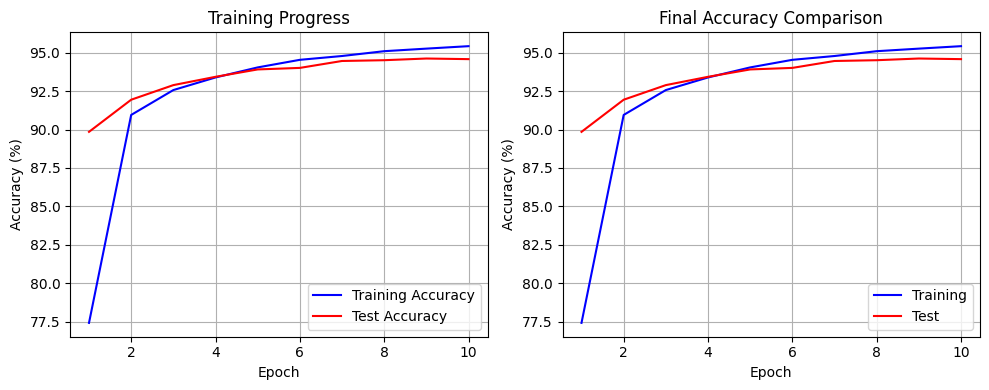

Final Training Accuracy: 95.42%
Final Test Accuracy: 94.58%


In [6]:
# Plot training progress (Style from LeNet-5)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'r-', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Training')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, 'r-', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Final Accuracy Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

In [7]:
# Save model and export ONNX
os.makedirs("outputs", exist_ok=True)

pth_path = os.path.join("outputs", "mnist_2hidden.pth")
torch.save(model.state_dict(), pth_path)
print(f"Saved weights to {pth_path}")

# Export to ONNX
onnx_path = os.path.join("outputs", "mnist_2hidden.onnx")
model_cpu = model.to("cpu").eval()
dummy = torch.randn(1, 1, 28, 28)
torch.onnx.export(
    model_cpu,
    dummy,
    onnx_path,
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {0: "batch"}, "logits": {0: "batch"}},
    opset_version=13
)
print(f"Exported ONNX to {onnx_path}")

Saved weights to outputs\mnist_2hidden.pth
Exported ONNX to outputs\mnist_2hidden.onnx


C:\Users\micha\AppData\Local\Temp\ipykernel_22644\1355785329.py:12: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


test2.png not found. Using random noise for demonstration.


C:\Users\micha\AppData\Local\Temp\ipykernel_22644\3856915852.py:7: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  canvas = Image.fromarray(np.random.randint(0, 255, (28, 28), dtype=np.uint8), mode='L')


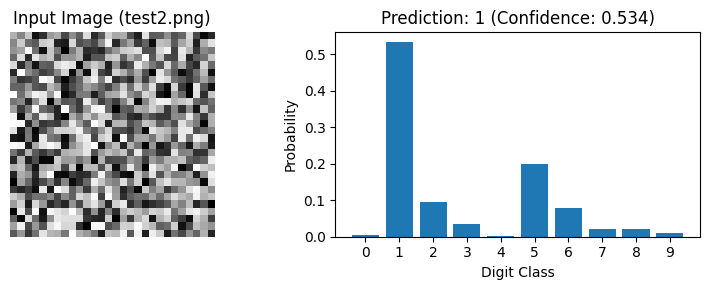

Prediction: 1
Confidence: 0.534


In [8]:
# Predict digit from test2.png using 2-hidden-layer model
img_path = "test2.png"

if not os.path.exists(img_path):
    # Create a dummy image if it doesn't exist for demonstration
    print(f"{img_path} not found. Using random noise for demonstration.")
    canvas = Image.fromarray(np.random.randint(0, 255, (28, 28), dtype=np.uint8), mode='L')
else:
    # Load and preprocess the image (same as other models)
    img = Image.open(img_path).convert("L")

    # Resize to 20x20 and center on 28x28 black canvas
    img_20 = img.resize((20, 20), Image.Resampling.LANCZOS)
    canvas = Image.new("L", (28, 28), color=0)
    offset = (4, 4)  # center 20x20 on 28x28
    canvas.paste(img_20, offset)

# Convert to tensor and normalize (same preprocessing as training)
to_tensor = transforms.ToTensor()
tensor = to_tensor(canvas)  # [0,1], (1,28,28)

# Auto-invert if background looks white
if tensor.mean().item() > 0.5:
    tensor = 1.0 - tensor

normalize = transforms.Normalize((0.1307,), (0.3081,))
tensor = normalize(tensor).unsqueeze(0)  # (1,1,28,28)

# Load trained model and predict
if not os.path.exists(pth_path):
    print("Model weights not found in current session.")
else:
    # Recreate model and load weights
    model_cpu = MNISTTwoHidden(input_dim=28*28, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, num_classes=10)
    state_dict = torch.load(pth_path, map_location="cpu")
    model_cpu.load_state_dict(state_dict)
    model_cpu.eval()

    # Make prediction
    with torch.no_grad():
        logits = model_cpu(tensor)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = int(logits.argmax(dim=1).item())
        confidence = float(probabilities[0][predicted_class].item())

    # Display results (LeNet-5 style)
    plt.figure(figsize=(8, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(canvas, cmap='gray')
    plt.title(f"Input Image ({img_path})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(range(10), probabilities[0].numpy())
    plt.xlabel('Digit Class')
    plt.ylabel('Probability')
    plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.3f})')
    plt.xticks(range(10))

    plt.tight_layout()
    plt.show()

    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.3f}")
